# Shortcomings of `sklearn.linear_model.Ridge`: constrained optimization and sample weighting

## Introduction
This notebook aims to introduce a version of `Ridge` that is more flexible, performant (for dense, long and
`NaN`-free data) and adopts a more natural convention, than `sklearn`'s implementation. Issues with the latter:
- many redundant checks that could be better off being handled by the user during the preprocessing stage.
- slow optimization when `positive=True`, lack of warm start and custom initialization, inability to provide
alternative bounds without introducing more variables.
- unnatural handling of weights and the penalty.
- the penalty/precision on the prior has to be diagonal.
- no option to adjust for the cross- and auto-correlations in the residuals.
- in the cross-validation context, the algorithm can be made significantly faster by caching Gram matrices and ,
which would make it high-throughput (as it should be) for doing forward/backward feature selection and optimizing
the penalty.

**Note**: this notebook is not concerned with running Ridge on sparse or wide data optimally, or fully expanding to
the generalized least squares framework (solving the GLS precisely can be compute-consuming and unnecessary).

## Method

To compare the performances of different implementations, we'll use synthetic data, with $L^2$ distance
between the "true" coefficients (which are always a combination of ones and zeros) and the inferred ones to measure the
precision of the inferrence. The code below generates the data.

In [1]:
from functools import lru_cache
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
from sklearn.datasets import make_low_rank_matrix
from matplotlib import pyplot as plt
from statsmodels import api as sm
from scipy.optimize import minimize

In [2]:
from dataclasses import dataclass


@dataclass(frozen=True)
class TestData:
    x: np.ndarray
    btrue: np.ndarray    
    b: np.ndarray
    ytrue: np.ndarray
    y: np.ndarray
    w: np.ndarray  # sample weights
    
# default params
n_samples = 100
n_features = 20
n_targets = 2
ac_kernel = (1.,)  # no autocorrelation in the residuals
betas_with_corr = False  # when generating betas
resid_with_corr = False  # no cross-correlation in the residuals
percent_ones = .1  # true betas (coefficients) start with this fraction of ones, followed by zeros
alpha = 1.  # characterizes the scale of the noise when generating betas


@lru_cache
def gen_data(
    n_samples: int,
    n_features: int,
    ac_kernel: tuple[float, ...],
    random_state: int,  # will go over range(10)
    resid_with_corr: 
    percent_ones: float,
) -> TestData:    
    assert n_features % 2 == 0
    x = make_low_rank_matrix(n_samples, n_features, random_state=random_state)
    
    
    return TestData(x, btrue, b, ytrue, y, w)

x = gen_data(1000, 100, 1, 42)    

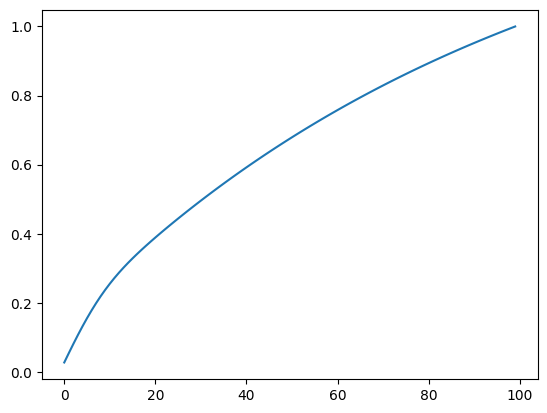

In [7]:
z = np.linalg.svd(x)[1]
plt.plot(z.cumsum() / z.sum())

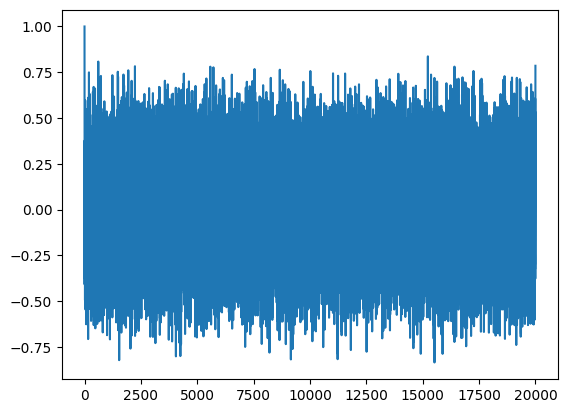

In [113]:
plt.plot(np.corrcoef(x)[0])

## 1. Redundant checks

In [101]:
n_samples = 20000
n_features = 200
n_targets = 2
x = make_low_rank_matrix(n_samples, n_features, tail_strength=.1)
betas = np.zeros((n_features, n_targets), dtype=float)
betas[:n_features//2, 0] = 1.
betas[n_features//2:, 1] = 1.
ytrue = x @ betas
noise = np.random.randn(*ytrue.shape)
y = ytrue + .1 * noise

In [102]:
from sklearn.linear_model._ridge import _solve_lbfgs, _preprocess_data
from scipy.optimize import lsq_linear

In [103]:
w = np.ones(len(x), dtype=float)
xsc, ysc, x_offset, y_offset, x_scale = _preprocess_data(
    x,
    y,
    fit_intercept=True,
    copy=True,
    sample_weight=w,
)

In [111]:
x_offset

array([ 9.29518601e-07, -7.47289807e-06, -3.94127916e-06, -1.14268499e-06,
       -1.03766312e-05,  3.52751891e-06, -1.36803762e-06,  3.87309369e-06,
        6.59686361e-06, -2.93718674e-06, -5.74137129e-06,  9.72704601e-06,
       -1.56260875e-06, -1.72852495e-06,  4.03724355e-07, -4.38483522e-06,
       -9.97413314e-06,  1.16439956e-06,  1.10384703e-05,  1.72353210e-07,
       -3.04231157e-06,  2.50006246e-06, -1.33066987e-07,  8.08549995e-06,
        8.38839048e-06, -3.36651982e-06, -1.80745589e-06, -5.12075478e-07,
        5.40962487e-06,  3.80925777e-06,  1.13266942e-06, -6.40151696e-06,
        4.80069330e-06,  3.09566178e-06, -1.32205244e-05, -2.86420764e-06,
       -3.63377488e-06,  2.62214200e-06,  3.93066994e-06,  8.20201072e-07,
        4.21076875e-06,  5.07062460e-08,  3.07039697e-06, -8.53953951e-07,
       -5.87160669e-06, -2.91060146e-08, -2.21179868e-06,  1.43477440e-05,
        2.67719338e-06, -4.23317922e-06,  3.95109468e-07,  1.99410867e-06,
        2.50943591e-06, -

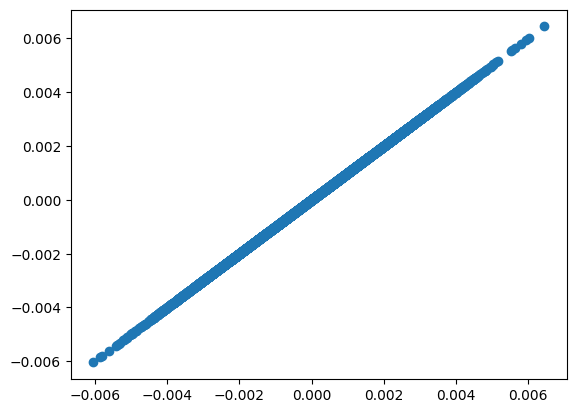

In [106]:
plt.scatter(x[:, 0], xsc[:, 0])

In [ ]:
plt.

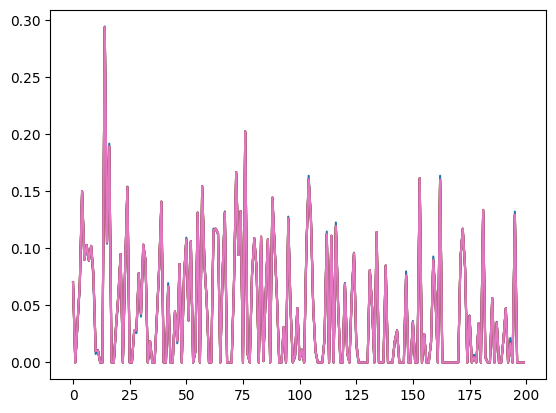

In [96]:
import time

diagnostics = dict()
for tol in [1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-16]:
    start = time.time()
    sklearn_betas = _solve_lbfgs(x, y, [1., 1.], tol=tol)    
    plt.plot(sklearn_betas[0])
    diagnostics[tol] = {'time': (time.time() - start), 'dist': np.linalg.norm(sklearn_betas[0] - betas[:, 0])}
diagnostics = pd.DataFrame(diagnostics).T
plt.show()

In [ ]:

    options = {}
    if max_iter is not None:
        options["maxiter"] = max_iter
    config = {
        "method": "L-BFGS-B",
        "tol": tol,
        "jac": True,
        "options": options,
    }
    if positive:
        config["bounds"] = [(0, np.inf)] * n_features

    if X_offset is not None and X_scale is not None:
        X_offset_scale = X_offset / X_scale
    else:
        X_offset_scale = None

    if sample_weight_sqrt is None:
        sample_weight_sqrt = np.ones(X.shape[0], dtype=X.dtype)

    coefs = np.empty((y.shape[1], n_features), dtype=X.dtype)

    for i in range(y.shape[1]):
        x0 = np.zeros((n_features,))
        y_column = y[:, i]

        def func(w):
            residual = X.dot(w) - y_column
            if X_offset_scale is not None:
                residual -= sample_weight_sqrt * w.dot(X_offset_scale)
            f = 0.5 * residual.dot(residual) + 0.5 * alpha[i] * w.dot(w)
            grad = X.T @ residual + alpha[i] * w
            if X_offset_scale is not None:
                grad -= X_offset_scale * residual.dot(sample_weight_sqrt)

            return f, grad

        result = optimize.minimize(func, x0, **config)
        if not result["success"]:
            warnings.warn(
                (
                    "The lbfgs solver did not converge. Try increasing max_iter "
                    f"or tol. Currently: max_iter={max_iter} and tol={tol}"
                ),
                ConvergenceWarning,
            )
        coefs[i] = result["x"]

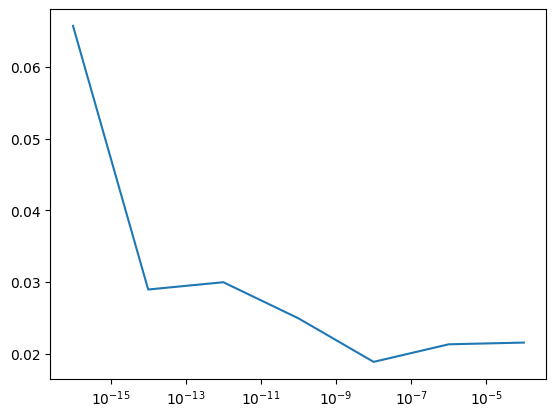

In [86]:
plt.plot(diagnostics['time'])
plt.xscale('log')

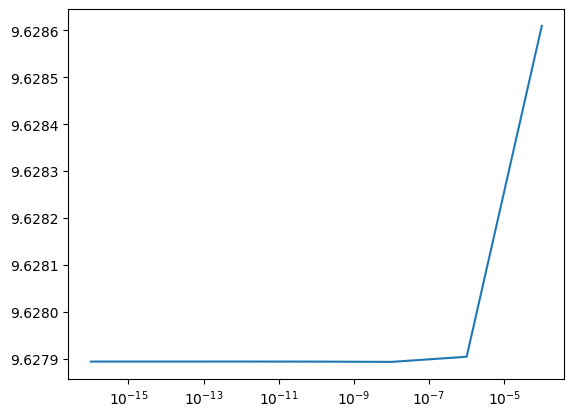

In [87]:
plt.plot(diagnostics['dist'])
plt.xscale('log')

In [72]:
sklearn_betas1 = _solve_lbfgs(x, y, [1., 1.], tol=1e-4)
sklearn_betas2 = _solve_lbfgs(x, y, [1., 1.], tol=1e-6)
sklearn_betas3 = _solve_lbfgs(x, y, [1., 1.], tol=1e-8)
sklearn_betas4 = _solve_lbfgs(x, y, [1., 1.], tol=1e-10)
sklearn_betas = _solve_lbfgs(x, y, [1., 1.], tol=1e-10)
sklearn_betas3 = _solve_lbfgs(x, y, [1., 1.], tol=1e-10)

In [73]:
np.linalg.norm(sklearn_betas1[0] - betas[:, 0])

9.628609672700367

In [74]:
np.linalg.norm(sklearn_betas2[0] - betas[:, 0])

9.627903787800282

In [75]:
np.linalg.norm(sklearn_betas3[0] - betas[:, 0])

9.627893468176179

(array([53.,  9., 10.,  6.,  7.,  7.,  4.,  1.,  1.,  2.]),
 array([0.       , 0.0142762, 0.0285524, 0.0428286, 0.0571048, 0.071381 ,
        0.0856572, 0.0999334, 0.1142096, 0.1284858, 0.142762 ]),
 <BarContainer object of 10 artists>)

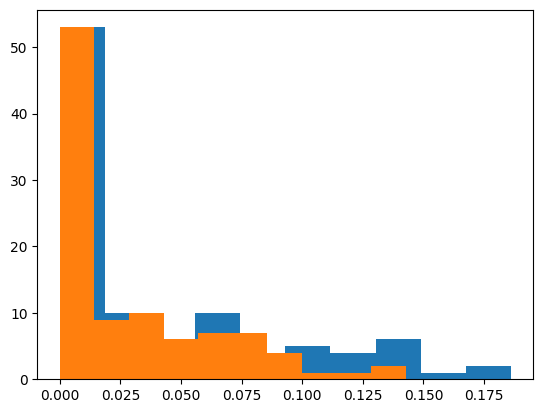

In [64]:
plt.hist(sklearn_betas3[0][:100])
plt.hist(sklearn_betas3[0][100:])

Text(0.5, 0, 'inferred by sklearn')

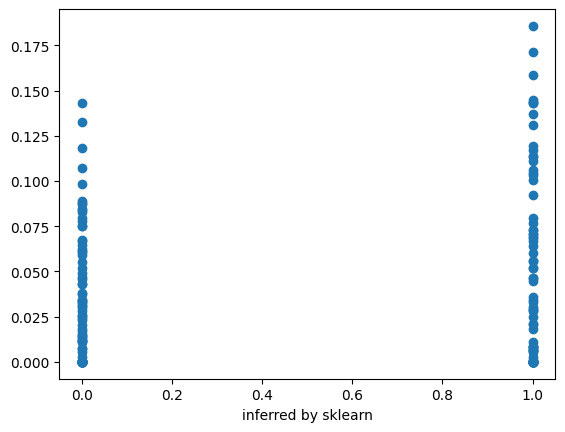

In [54]:
plt.scatter(betas[:, 0], sklearn_betas[0])
plt.xlabel('true')
plt.xlabel('inferred by sklearn')

In [45]:
betas.shape

(2, 100)

In [ ]:
Ridge(positive=True).fit(x, y[:, :1])

In [40]:
%timeit -n10 Ridge(positive=True).fit(x, y[:, :1])

6.25 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def fun():
    


%timeit -n10 minimize(fun, x0=bounds=[(0, np.inf)] * n_features)

In [32]:
sm.OLS(y[:, 1], sm.add_constant(x)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     4.318
Date:                Mon, 20 May 2024   Prob (F-statistic):           8.48e-33
Time:                        16:32:52   Log-Likelihood:                 963.93
No. Observations:                1000   AIC:                            -1726.
Df Residuals:                     899   BIC:                            -1230.
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -0.951      0.342      -0.010       0.003
x1             0.0197      1.687      0.012      0.991      -3.292       3.331
x2             1.8586      1.508      1.232      0.218      -1.102       4.819
x3             1.6244      1.669      0.973      0.331      -1.651       4.900
x4            -4.1536      1.703     -2.438      0.015      -7.497      -0.810
x5            -0.9566      1.599     -0.598      0.550      -4.095       2.182
x6            -0.4206      1.623     -0.259      0.796      -3.605       2.764
x7             3.3792      1.676      2.016      0.044       0.090       6.668
x8             1.9502      1.470      1.327      0.185      -0.934       4.835
x9            -1.6374      1.687     -0.971      0.332      -4.948       1.673
x10            0.9596      1.713      0.560      0.575      -2.402       4.321
x11           -0.9508      1.698     -0.560      0.576      -4.284       2.382
x12           -0.4045      1.644     -0.246      0.806      -3.631       2.822
x13           -1.2757      1.660     -0.769      0.442      -4.533       1.982
x14            0.2930      1.770      0.166      0.869      -3.181       3.767
x15           -0.2479      1.820     -0.136      0.892      -3.820       3.324
x16           -0.2480      1.662     -0.149      0.881      -3.509       3.013
x17            1.5107      1.523      0.992      0.322      -1.479       4.501
x18           -0.1551      1.645     -0.094      0.925      -3.383       3.073
x19           -1.9168      1.740     -1.102      0.271      -5.332       1.498
x20            2.8856      1.610      1.793      0.073      -0.273       6.045
x21           -2.1060      1.562     -1.349      0.178      -5.171       0.959
x22           -0.3006      1.496     -0.201      0.841      -3.236       2.635
x23            0.1455      1.573      0.093      0.926      -2.941       3.232
x24            0.4813      1.683      0.286      0.775      -2.821       3.784
x25            0.5120      1.675      0.306      0.760      -2.776       3.800
x26            0.4330      1.599      0.271      0.787      -2.704       3.570
x27            1.0492      1.762      0.596      0.552      -2.408       4.507
x28           -4.5114      1.547     -2.916      0.004      -7.547      -1.475
x29            4.0338      1.665      2.422      0.016       0.765       7.302
x30            2.1989      1.599      1.375      0.169      -0.939       5.336
x31           -1.1772      1.656     -0.711      0.477      -4.427       2.072
x32            0.2552      1.653      0.154      0.877      -2.989       3.500
x33           -0.9983      1.640     -0.609      0.543      -4.217       2.221
x34           -1.4211      1.673     -0.849      0.396      -4.705       1.863
x35            1.7262      1.642      1.051      0.294      -1.497       4.949
x3